# Task 7.1D: Function approximation implementation
_By Sudaksh Mishra (Student ID: 222348309)_

In [1]:
import gymnasium as gym
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Importing Taxi-v3 environment
env_name = 'Taxi-v3'
env = gym.make(env_name, render_mode='human')
observation, info = env.reset(seed=6)
print(list(env.decode(observation)))
env.close()

[2, 3, 1, 3]


In [3]:
num_states = env.observation_space.n
num_actions = env.action_space.n
print('Number of states:', num_states)
print('Number of actions:', num_actions)

Number of states: 500
Number of actions: 6


The action shape is (1,) in the range {0, 5} indicating which direction to move the taxi or to pickup/drop off passengers.

- 0: Move south (down)
- 1: Move north (up)
- 2: Move east (right)
- 3: Move west (left)
- 4: Pickup passenger
- 5: Drop off passenger

Reference: https://gymnasium.farama.org/environments/toy_text/taxi/

Semi-Gradient SARSA(0) is used to solve the problem. The algorithm is implemented in the following steps:

1. Initialize the Q-table with zeros
2. Choose an action using epsilon-greedy policy
3. Take the action and observe the reward and next state
4. Update the Q-table using the following formula:
    - Q(s, a) = Q(s, a) + alpha * (reward + gamma * Q(s', a') - Q(s, a))
5. Repeat steps 2-4 until the episode is finished

The algorithm is run for 1000 episodes and the average reward per episode is plotted.

In [4]:
def random_action(a, eps=0.1):
    p = np.random.rand()
    if p < eps:
        return np.random.choice([0, 1, 2, 3, 4, 5])
    else:
        return a

In [23]:
class Model:
    def __init__(self):
        self.alpha = 0.5
        self.gamma = 0.9
        self.eps = 1.0
        self.theta = np.zeros(73)

    def sa2x(self, s, a):
        x = np.zeros(73)

        for i in range(num_actions):
            x[0 + 12*i]  = s[0]/2 if a == i else 0
            x[1 + 12*i]  = s[1]/5 if a == i else 0
            x[2 + 12*i]  = s[2]/5 if a == i else 0
            x[3 + 12*i]  = s[0]*s[0]*s[1]/20 if a == i else 0
            x[4 + 12*i]  = s[0]*s[1]*s[1]/50 if a == i else 0
            x[5 + 12*i]  = s[0]*s[0]*s[2]/20 if a == i else 0
            x[6 + 12*i]  = s[0]*s[2]*s[2]/50 if a == i else 0
            x[7 + 12*i]  = s[1]*s[1]*s[2]/125 if a == i else 0
            x[8 + 12*i]  = s[1]*s[2]*s[2]/125 if a == i else 0
            x[9 + 12*i]  = s[0]*s[0]/25 if a == i else 0
            x[10 + 12*i] = s[1]*s[1]/25 if a == i else 0
            x[11 + 12*i] = s[2]*s[2]/25 if a == i else 0

        x[72] = 1
        return x

    def predict(self, s, a):
        x = self.sa2x(s, a)
        return self.theta.dot(x)

In [24]:
def getQs(model, s):
    Qs = np.zeros(num_actions)
    for a in range(num_actions):
        x = model.sa2x(s, a)
        Qs[a] = model.theta.dot(x)
    return Qs

In [25]:
IDX = 0
SA2IDX = {}

states = [(i, j, k) for i in range(2) for j in range(5) for k in range(5)]

for i in range(2): # passenger state
    for j in range(5):
        for k in range(5):
            SA2IDX[(i, j, k)] = {}
            for a in range(6):
                SA2IDX[(i, j, k)][a] = IDX
                IDX += 1

print('State-Action to Index Mapping:', SA2IDX)

State-Action to Index Mapping: {(0, 0, 0): {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}, (0, 0, 1): {0: 6, 1: 7, 2: 8, 3: 9, 4: 10, 5: 11}, (0, 0, 2): {0: 12, 1: 13, 2: 14, 3: 15, 4: 16, 5: 17}, (0, 0, 3): {0: 18, 1: 19, 2: 20, 3: 21, 4: 22, 5: 23}, (0, 0, 4): {0: 24, 1: 25, 2: 26, 3: 27, 4: 28, 5: 29}, (0, 1, 0): {0: 30, 1: 31, 2: 32, 3: 33, 4: 34, 5: 35}, (0, 1, 1): {0: 36, 1: 37, 2: 38, 3: 39, 4: 40, 5: 41}, (0, 1, 2): {0: 42, 1: 43, 2: 44, 3: 45, 4: 46, 5: 47}, (0, 1, 3): {0: 48, 1: 49, 2: 50, 3: 51, 4: 52, 5: 53}, (0, 1, 4): {0: 54, 1: 55, 2: 56, 3: 57, 4: 58, 5: 59}, (0, 2, 0): {0: 60, 1: 61, 2: 62, 3: 63, 4: 64, 5: 65}, (0, 2, 1): {0: 66, 1: 67, 2: 68, 3: 69, 4: 70, 5: 71}, (0, 2, 2): {0: 72, 1: 73, 2: 74, 3: 75, 4: 76, 5: 77}, (0, 2, 3): {0: 78, 1: 79, 2: 80, 3: 81, 4: 82, 5: 83}, (0, 2, 4): {0: 84, 1: 85, 2: 86, 3: 87, 4: 88, 5: 89}, (0, 3, 0): {0: 90, 1: 91, 2: 92, 3: 93, 4: 94, 5: 95}, (0, 3, 1): {0: 96, 1: 97, 2: 98, 3: 99, 4: 100, 5: 101}, (0, 3, 2): {0: 102, 1: 103, 2: 104, 3: 10

In [44]:
model = Model()
print(model.theta)
print(model.sa2x((0, 1, 4), 2))
print(model.predict((0, 1, 4), 2))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.2   0.8   0.    0.    0.    0.    0.032 0.128 0.    0.04  0.64
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 1.   ]
0.0


In [45]:
Qs = getQs(model, (0, 1, 4))
action = Qs.argmax()
action

0

In [46]:
num_episodes = 10001
decay = 1.
decay_2 = 1.
deltas = []

render = 2000
passenger_location = (0, 0, 4)
destination = (1, 4, 3)

for i in range(num_episodes):
    # Decay alpha and epsilon
    if i % 100 == 0:
        decay += 0.0005
        decay_2 += 0.0005
        model.eps /= decay
        model.alpha /= decay_2
        if model.alpha < 0.1:
            model.alpha = 0.1

    if i % render == 0:
        print('Episode:', i, 'Epsilon:', model.eps, 'Theta:', model.theta, 'Alpha:', model.alpha)
        env = gym.make(env_name, render_mode='human')
    else:
        env = gym.make(env_name)
    env._max_episode_steps = 100
    observation, info = env.reset(seed=6)
    reward = 0
    observation = tuple([0] + list(env.decode(observation))[:2])

    Qs = getQs(model, observation)

    action = Qs.argmax()
    action = random_action(action, eps=model.eps)
    reward_given = False
    biggest_change = 0
    done = False
    
    while not done:
        observation_, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        # Adding the passenger state to the observation and adjusting the reward
        if action == 4 and observation == passenger_location:
            observation_ = tuple([1] + list(env.decode(observation_))[:2])
            # Reward for picking passenger up
            if not reward_given:
                reward_given = True
                reward = 10
        elif action == 5:
            observation_ = tuple([0] + list(env.decode(observation_))[:2])
            # Terminate the episode if there is an illegal drop off
            if observation != destination:
                done = True
                reward = -30
            else:
                reward = 30
        else:
            if observation[0] == 1:
                observation_ = tuple([1] + list(env.decode(observation_))[:2])
            else:
                observation_ = tuple([0] + list(env.decode(observation_))[:2])

        # Printing the state, action and reward
        if i % render == 0:
            print('State:', observation, ' Action:', action, 'Reward:', reward)
        
        old_theta = model.theta.copy()
        if done:
            model.theta += model.alpha * (reward - model.predict(observation, action)) * model.sa2x(observation, action)
        else:
            Qs_ = getQs(model, observation_)
            action_, maxQs_a_ = Qs_.argmax(), Qs_.max()
            action_ = random_action(action_, eps = model.eps)
            
            model.theta += model.alpha * (reward + model.gamma * maxQs_a_ - model.predict(observation, action)) * model.sa2x(observation, action)
            
            # Update observation and action
            observation = observation_
            action = action_
        
        biggest_change = max(biggest_change, np.abs(model.theta - old_theta).sum())
        deltas.append(biggest_change)
    clear_output(wait=True)
    env.close()

Episode: 10000 Epsilon: 0.07942007610118602 Theta: [ 21.95782341  14.82385433  37.34030014  23.20088509  20.74428802
  -9.12127421 -30.3505411   -6.88738185 -12.84729429   1.75662587
 -21.20501214 -23.51905737   1.71741753   7.8388061   37.29245176
  18.16331034  21.19853763  -8.58564448 -23.09304136 -10.33218398
 -17.57125657   0.1373934   -3.61230411  -7.52520008  -1.43727091
   7.71040839  48.16740671  14.85651595  19.88863279  -6.43382136
 -13.06222538  -6.30970053 -13.78975546  -0.11498167  -6.22296132
 -24.35624473   9.18687741  11.82907866  24.58180331  12.15157752
  11.71387566  -1.37336786  -6.14462683 -11.13765115   2.30843186
   0.73495019 -11.68654618  -7.20769172   1.66061755 -12.52184013
  18.51421384  40.64811397  28.93759375 -12.16290969 -33.38828814
  11.39786045 -46.99066182   0.1328494   15.91589766  18.82307195
 -21.17026892 -48.27539961   1.63499204  30.90642091 103.59492535
  23.76605138 -19.30938386  82.45652535 -51.7124025   -1.69362151
  45.60381117 -29.5914857

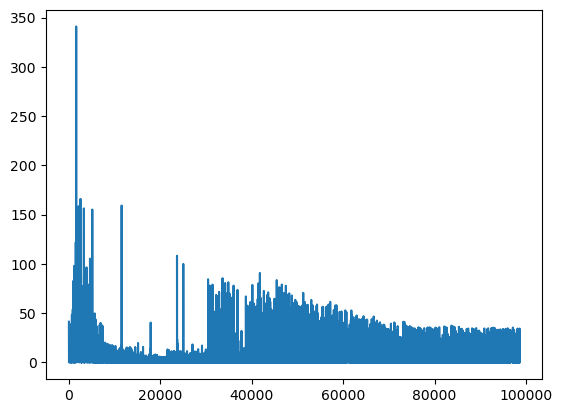

In [47]:
plt.plot(deltas)
plt.show()

In [48]:
policy = {}
V = {}
Q = {}
for state in states:
    Qs = getQs(model, state)
    Q[state] = Qs
    action = Qs.argmax()
    policy[state] = action
    V[state] = Qs.max()

In [49]:
# Convert policy to matrix format
action_mapping = {
    0: 'S',
    1: 'N',
    2: 'E',
    3: 'W',
    4: 'P',
    5: 'D'
}

policy_matrix = np.zeros((2, 5, 5), dtype='<U2')
V_matrix = np.zeros((2, 5, 5))

for ps in range(2):
    for s1 in range(5):
        for s2 in range(5):
            state = (ps, s1, s2)
            policy_matrix[ps, s1, s2] = action_mapping[policy[state]]
            V_matrix[ps, s1, s2] = V[state] 

print('Policy:\n', policy_matrix)
print('Value:\n', V_matrix)

Policy:
 [[['S' 'E' 'E' 'E' 'P']
  ['S' 'E' 'E' 'E' 'N']
  ['W' 'E' 'E' 'E' 'N']
  ['N' 'E' 'E' 'E' 'N']
  ['N' 'E' 'E' 'E' 'E']]

 [['S' 'S' 'S' 'S' 'W']
  ['S' 'S' 'S' 'S' 'W']
  ['S' 'S' 'S' 'S' 'W']
  ['S' 'S' 'S' 'S' 'W']
  ['D' 'D' 'D' 'D' 'W']]]
Value:
 [[[-9.87731951 -1.2170161   5.49501741 10.25878103 16.97648879]
  [-7.75562217 -0.08394416  6.2466913  10.40843916 14.01729348]
  [-7.01553543  0.45044999  6.29874445  9.75753358 11.91134845]
  [-6.47277016  0.38616637  5.65117686  8.30606431  8.85508458]
  [-5.91598019 -0.27679504  4.30398852  6.05403134  4.97333341]]

 [[ 1.16910849  6.63174209  8.99843616  8.26919069  7.41728897]
  [ 4.86629772 10.17126373 12.17484406 10.87703872 10.09657369]
  [ 7.7000768  12.73748616 14.26806369 12.29180942 11.59668006]
  [ 9.67044573 14.33040937 15.27809505 12.51350279 11.91760809]
  [11.52415994 20.67380846 23.45548439 19.86918775 11.05935778]]]


In [50]:
# Testing
env = gym.make(env_name, render_mode='human')
env._max_episode_steps = 30
observation, info = env.reset(seed=6)
observation = tuple([0] + list(env.decode(observation))[:2])
Qs = getQs(model, observation)
action = Qs.argmax()
passenger_picked_up = False
done = False
while not done:
    observation_, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if action == 4 and observation == passenger_location:
        observation_ = tuple([1] + list(env.decode(observation_))[:2])
    elif action == 5:
        observation_ = tuple([0] + list(env.decode(observation_))[:2])
    else:
        if observation[0] == 1:
            observation_ = tuple([1] + list(env.decode(observation_))[:2])
        else:
            observation_ = tuple([0] + list(env.decode(observation_))[:2])
    observation = observation_
    Qs = getQs(model, observation)
    action = Qs.argmax()
    print('State:', observation, ' Action:', action, 'Reward:', reward)

env.close()

State: (0, 2, 4)  Action: 1 Reward: -1
State: (0, 1, 4)  Action: 1 Reward: -1
State: (0, 0, 4)  Action: 4 Reward: -1
State: (1, 0, 4)  Action: 3 Reward: -1
State: (1, 0, 3)  Action: 0 Reward: -1
State: (1, 1, 3)  Action: 0 Reward: -1
State: (1, 2, 3)  Action: 0 Reward: -1
State: (1, 3, 3)  Action: 0 Reward: -1
State: (1, 4, 3)  Action: 5 Reward: -1
State: (0, 4, 3)  Action: 2 Reward: 20


In [52]:
print(model.theta)

[ 21.95236088  14.84305054  37.3337451   23.20568415  20.76038449
  -9.12291297 -30.35250761  -6.86806609 -12.84038366   1.75618887
 -21.1728192  -23.52299039   1.71741753   7.84197319  37.31715131
  18.16331034  21.19853763  -8.58564448 -23.09304136 -10.33263974
 -17.56922963   0.1373934   -3.61287381  -7.50544044  -1.43727091
   7.71359843  48.17219177  14.85651595  19.88863279  -6.43382136
 -13.06222538  -6.30893492 -13.78860705  -0.11498167  -6.2216853
 -24.35337369   9.13845886  11.82907866  24.50433364  12.15157752
  11.71387566  -1.39273528  -6.1756147  -11.13765115   2.30843186
   0.73107671 -11.68654618  -7.26966746   1.66061755 -12.52184013
  18.51091443  40.64811397  28.93759375 -12.16290969 -33.38828814
  11.39786045 -46.99066182   0.1328494   15.91589766  18.82043242
 -20.42332412 -47.08028793   2.53132579  31.20519883 104.07297002
  23.99013482 -19.04048374  83.03017895 -51.28216229  -1.63386593
  46.55990051 -29.05368554  -9.87731951]
